# Task 2: Signal Reconstruction with Random Fourier Features

In this notebook, we explore a powerful technique for representing complex signals: learning a continuous function that maps coordinates to signal values. This approach, often called a "Neural Field," allows us to represent a signal at any resolution. We will use Random Fourier Features (RFF) to build this function.

### The Math: From Kernels to Linear Models

The core idea is to approximate a complex kernel, like the Gaussian Radial Basis Function (RBF) kernel, which is powerful but computationally expensive.

**1. The RBF Kernel:**
The RBF kernel measures the similarity between two points $\mathbf{x}$ and $\mathbf{x'}$ as:
$$
K(\mathbf{x}, \mathbf{x'}) = \exp\left(-\frac{\|\mathbf{x} - \mathbf{x'}\|^2}{2\sigma^2}\right)
$$
where $\sigma$ controls the "width" of the similarity.

**2. Bochner's Theorem and the Feature Map:**
This theorem allows us to approximate the kernel with a feature map $\mathbf{z}(\mathbf{x})$ created by sampling random frequencies $\boldsymbol{\omega}_j$ from a Gaussian distribution:
$$
\mathbf{z}(\mathbf{x}) = \sqrt{\frac{1}{D}} \left[ \cos(\boldsymbol{\omega}_1^T \mathbf{x}), \sin(\boldsymbol{\omega}_1^T \mathbf{x}), \dots, \cos(\boldsymbol{\omega}_D^T \mathbf{x}), \sin(\boldsymbol{\omega}_D^T \mathbf{x}) \right]
$$
This transforms the problem so that $K(\mathbf{x}, \mathbf{x'}) \approx \mathbf{z}(\mathbf{x})^T \mathbf{z}(\mathbf{x'})$. This means we can feed these high-dimensional RFFs into a simple **linear model** to learn a highly non-linear function.

We will conduct three experiments to find the best reconstruction:
1.  **Best-Effort Single-Scale RFF + Linear Model:** Pushing the simplest architecture to its limit with tuned hyperparameters.
2.  **Multi-Scale RFF + Linear Model:** Engineering better features to improve the linear model's performance.
3.  **Multi-Scale RFF + MLP:** Using a more powerful, non-linear model for the highest fidelity.

In [1]:
import torch
import numpy as np
import sys
import os
from torchvision.transforms.functional import center_crop

# Add the src directory to the Python path
sys.path.append(os.path.abspath(os.path.join('..', 'src')))

# Import our custom modules, now correctly importing RFFEncoder
from data_loader import load_image, load_audio
from models import LinearRegressionModel, SignalMLP
from training import train_rff_model
from utils import (
    create_coordinate_map, 
    get_pixels_from_image, 
    RFFEncoder, # <-- CORRECTED IMPORT
    calculate_image_metrics,
    create_time_coordinates,
    calculate_audio_metrics
)
from visualize import plot_reconstruction, plot_audio

# Setup device
if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

print(f"Using device: {device}")

/Users/devanshlodha/Documents/github/signal-synth-ml/signal-synth-env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using device: mps


## Part 1: Image Reconstruction

We will learn a function $f: \mathbb{R}^2 \to \mathbb{R}^3$ that maps 2D pixel coordinates `(y, x)` to 3D RGB color values. We will use a larger `512x512` image crop for a more detailed result.

In [2]:
# --- Load and Prepare a Larger Image ---
IMG_PATH = '../data/images/borgir.jpg'
original_image = load_image(IMG_PATH, device)

# Use a larger 512x512 center crop
img_to_reconstruct = center_crop(original_image, output_size=[512, 512])

# Create the coordinate map and get corresponding pixel values
coords = create_coordinate_map(img_to_reconstruct.shape[1], img_to_reconstruct.shape[2], device)
pixels = get_pixels_from_image(img_to_reconstruct)

print(f"Image shape: {img_to_reconstruct.shape}")
print(f"Coordinate map shape: {coords.shape}")
print(f"Pixel values shape: {pixels.shape}")

Image shape: torch.Size([3, 512, 512])
Coordinate map shape: torch.Size([262144, 2])
Pixel values shape: torch.Size([262144, 3])


### Experiment 1: Best-Effort Single-Scale RFF + Linear Model

Here, we use a single set of RFFs but with a large number of features and carefully tuned hyperparameters to get the best possible result from this simple approach.

Creating single-scale RFFs...
Training Linear Model on Single-Scale Features...


Training RFF Model: 100%|██████████| 3000/3000 [05:07<00:00,  9.76it/s, loss=0.214261]



Image (Correctly Tuned Single-Scale RFF) -> RMSE: 0.4628, PSNR: 6.69 dB


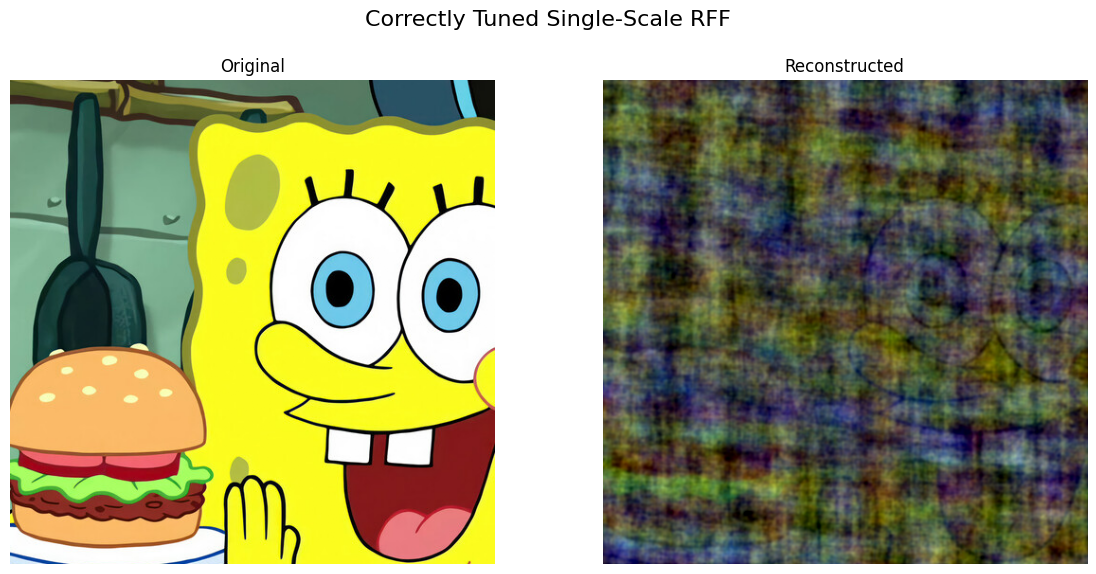

In [3]:
# --- Experiment 1: Correctly Tuned Single-Scale RFF + Linear Model ---
MAPPING_SIZE = 2048
SCALE = 32.0
EPOCHS = 3000
LEARNING_RATE = 1e-4

# --- Feature Creation (using the new Encoder) ---
print("Creating single-scale RFFs...")
encoder_single = RFFEncoder(d_in=2, mapping_size_per_scale=MAPPING_SIZE, scales=[SCALE], device=device)
single_scale_rff = encoder_single.encode(coords)

# --- Model Training ---
linear_model_single = LinearRegressionModel(in_features=encoder_single.d_out, out_features=3)
print("Training Linear Model on Single-Scale Features...")
train_rff_model(linear_model_single, single_scale_rff, pixels, EPOCHS, LEARNING_RATE, device)

# --- Reconstruction and Evaluation ---
linear_model_single.eval()
with torch.no_grad():
    recon_pixels = linear_model_single(single_scale_rff)
reconstructed_img_single = recon_pixels.reshape(512, 512, 3).permute(2, 0, 1)
rmse, psnr = calculate_image_metrics(img_to_reconstruct, reconstructed_img_single)
print(f"\nImage (Correctly Tuned Single-Scale RFF) -> RMSE: {rmse:.4f}, PSNR: {psnr:.2f} dB")
plot_reconstruction(img_to_reconstruct, reconstructed_img_single, "Correctly Tuned Single-Scale RFF")

### Experiment 2: Multi-Scale RFF + Linear Model

Now, we engineer a superior feature set by combining RFFs from multiple scales (low, medium, and high frequency). This gives the same simple linear model much more information to work with.

Creating multi-scale RFFs...


Training Linear Model on Multi-Scale Features...


Training RFF Model: 100%|██████████| 4000/4000 [04:21<00:00, 15.28it/s, loss=0.018334]



Image (Multi-Scale RFF) -> RMSE: 0.1354, PSNR: 17.37 dB


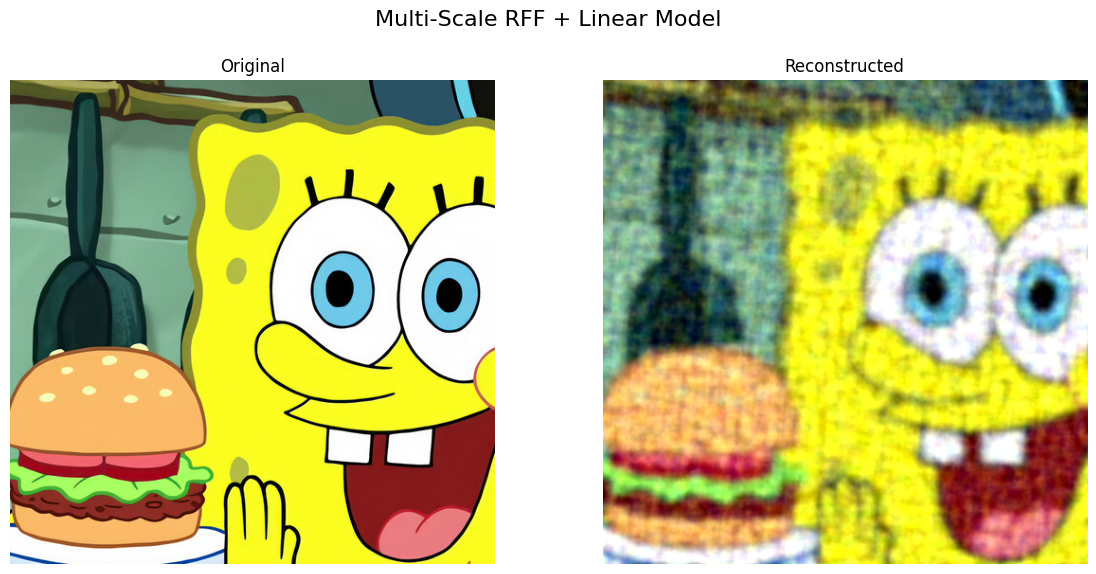

In [4]:
# --- Hyperparameters ---
MS_SCALES = [2.0, 10.0, 50.0] 
MS_MAPPING_SIZE_PER_SCALE = 1024
MS_EPOCHS = 4000
MS_LEARNING_RATE = 1e-4

# --- Feature Creation (using the new Encoder) ---
print("Creating multi-scale RFFs...")
encoder_multi = RFFEncoder(d_in=2, mapping_size_per_scale=MS_MAPPING_SIZE_PER_SCALE, scales=MS_SCALES, device=device)
multi_scale_rff = encoder_multi.encode(coords)

# --- Model Training ---
linear_model_multi = LinearRegressionModel(in_features=encoder_multi.d_out, out_features=3)
print("Training Linear Model on Multi-Scale Features...")
train_rff_model(linear_model_multi, multi_scale_rff, pixels, MS_EPOCHS, MS_LEARNING_RATE, device)

# --- Reconstruction and Evaluation ---
linear_model_multi.eval()
with torch.no_grad():
    recon_pixels_ms = linear_model_multi(multi_scale_rff)
reconstructed_img_multi = recon_pixels_ms.reshape(512, 512, 3).permute(2, 0, 1)
rmse, psnr = calculate_image_metrics(img_to_reconstruct, reconstructed_img_multi)
print(f"\nImage (Multi-Scale RFF) -> RMSE: {rmse:.4f}, PSNR: {psnr:.2f} dB")
plot_reconstruction(img_to_reconstruct, reconstructed_img_multi, "Multi-Scale RFF + Linear Model")

### Experiment 3: Multi-Scale RFF + MLP

Finally, we use the best features (multi-scale RFFs) and feed them into our more powerful `SignalMLP`. This combination of strong features and a non-linear model should yield the highest fidelity.

Training MLP on Multi-Scale Features...


Training RFF Model: 100%|██████████| 5000/5000 [1:06:31<00:00,  1.25it/s, loss=0.000066]



Image (MLP + Multi-Scale RFF) -> RMSE: 0.0041, PSNR: 47.78 dB


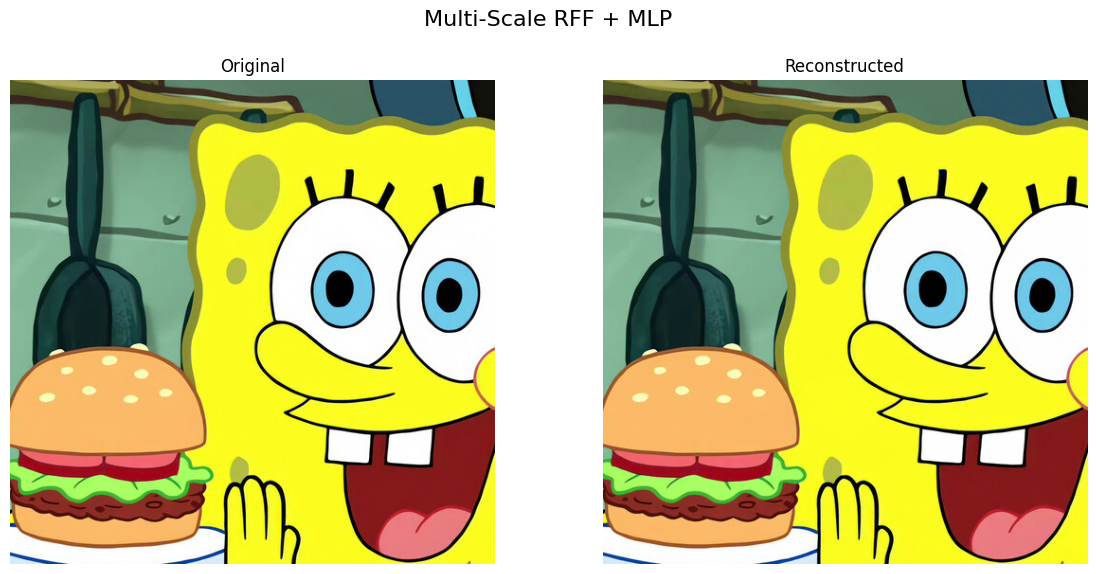

In [5]:
# --- Hyperparameters ---
MLP_HIDDEN_FEATURES = 256
MLP_NUM_HIDDEN_LAYERS = 4
MLP_EPOCHS = 5000
MLP_LEARNING_RATE = 1e-4

# --- Model Training ---
# IMPORTANT: We re-use the 'encoder_multi' and 'multi_scale_rff' from the previous cell.
mlp_model = SignalMLP(
    in_features=encoder_multi.d_out,
    out_features=3, # RGB
    hidden_features=MLP_HIDDEN_FEATURES,
    num_hidden_layers=MLP_NUM_HIDDEN_LAYERS
)
print("Training MLP on Multi-Scale Features...")
# Note: The MLP output is tanh, so the target pixels should be scaled to [-1, 1]
train_rff_model(mlp_model, multi_scale_rff, pixels * 2 - 1, MLP_EPOCHS, MLP_LEARNING_RATE, device)

# --- Reconstruction and Evaluation ---
mlp_model.eval()
with torch.no_grad():
    # The tanh output is in [-1, 1], so we scale it back to [0, 1] for image display.
    recon_pixels_mlp = (mlp_model(multi_scale_rff) + 1) / 2
reconstructed_img_mlp = recon_pixels_mlp.reshape(512, 512, 3).permute(2, 0, 1)
rmse, psnr = calculate_image_metrics(img_to_reconstruct, reconstructed_img_mlp)
print(f"\nImage (MLP + Multi-Scale RFF) -> RMSE: {rmse:.4f}, PSNR: {psnr:.2f} dB")
plot_reconstruction(img_to_reconstruct, reconstructed_img_mlp, "Multi-Scale RFF + MLP")

## Part 2: Audio Reconstruction

We repeat the same series of experiments for a 1D audio signal, learning a function $g: \mathbb{R}^1 \to \mathbb{R}^1$ that maps time `t` to amplitude `A`.

--- Starting Audio Experiment 1: Single-Scale Linear ---


Training RFF Model: 100%|██████████| 3000/3000 [01:36<00:00, 31.01it/s, loss=0.000464]


Audio (Single-Scale) -> RMSE: 0.0215, SNR: 2.01 dB

--- Starting Audio Experiment 2: Multi-Scale Linear ---


Training RFF Model: 100%|██████████| 4000/4000 [03:02<00:00, 21.89it/s, loss=0.000520]


Audio (Multi-Scale) -> RMSE: 0.0228, SNR: 1.51 dB

--- Starting Audio Experiment 3: Multi-Scale MLP ---


Training RFF Model: 100%|██████████| 4000/4000 [1:42:22<00:00,  1.54s/it, loss=0.000073]


Audio (MLP) -> RMSE: 0.0086, SNR: 10.01 dB


--- Original Audio ---


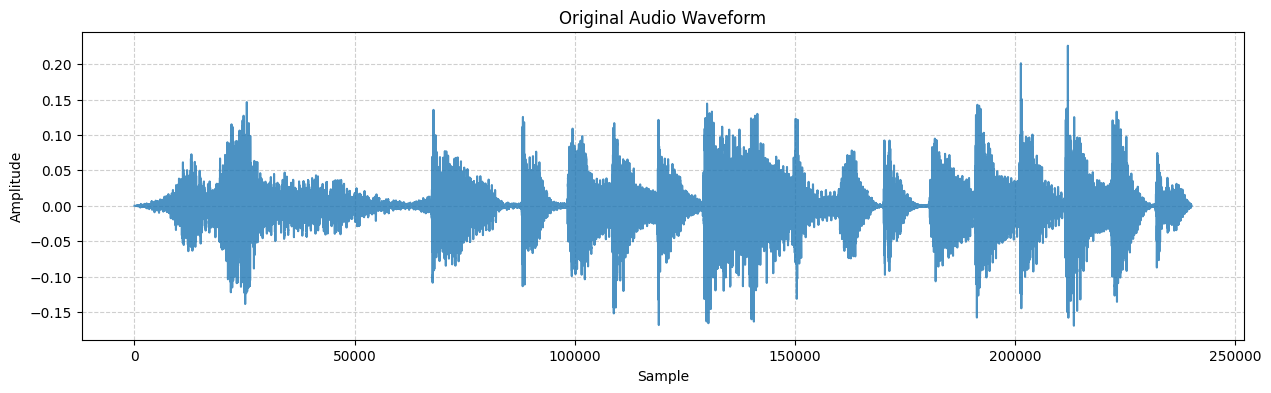


--- Reconstructed Audio (Multi-Scale RFF + MLP) ---


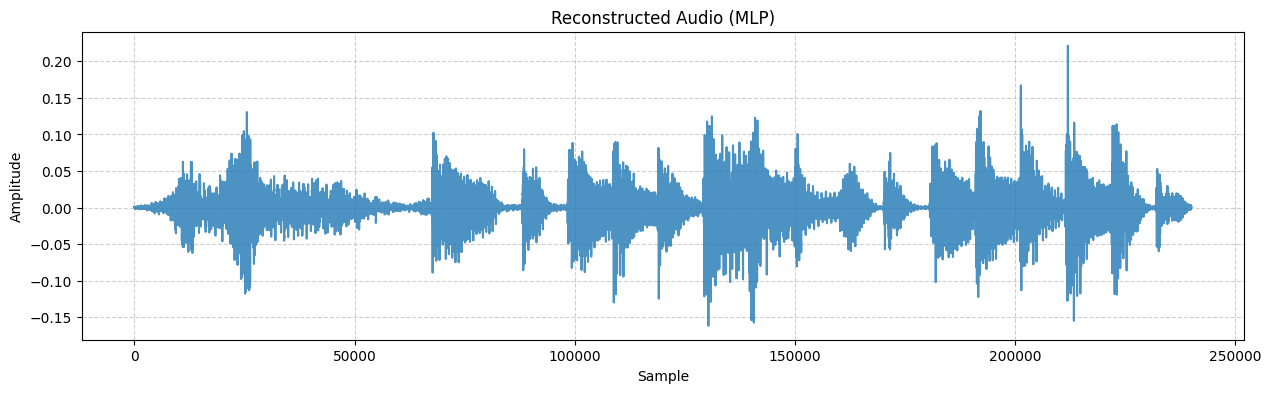

In [6]:
# --- Load and Prepare Audio Data ---
AUDIO_PATH = '../data/audio/borgir.wav'
original_audio, sample_rate = load_audio(AUDIO_PATH, duration_secs=5)
original_audio = original_audio.to(device)
time_coords = create_time_coordinates(original_audio.numel(), device)
amplitudes = original_audio.unsqueeze(-1)

# --- Audio Experiment 1: Single-Scale RFF + Linear Model ---
print("--- Starting Audio Experiment 1: Single-Scale Linear ---")
AUDIO_SCALE = 256.0
AUDIO_MAPPING_SIZE = 2048
AUDIO_EPOCHS = 3000
AUDIO_LR = 1e-4

audio_encoder_single = RFFEncoder(d_in=1, mapping_size_per_scale=AUDIO_MAPPING_SIZE, scales=[AUDIO_SCALE], device=device)
audio_rff_single = audio_encoder_single.encode(time_coords)
audio_linear_single = LinearRegressionModel(audio_encoder_single.d_out, 1)
train_rff_model(audio_linear_single, audio_rff_single, amplitudes, AUDIO_EPOCHS, AUDIO_LR, device)
with torch.no_grad():
    recon_audio_single = audio_linear_single(audio_rff_single).squeeze()
rmse, snr = calculate_audio_metrics(original_audio, recon_audio_single)
print(f"Audio (Single-Scale) -> RMSE: {rmse:.4f}, SNR: {snr:.2f} dB\n")

# --- Audio Experiment 2: Multi-Scale RFF + Linear Model ---
print("--- Starting Audio Experiment 2: Multi-Scale Linear ---")
AUDIO_MS_SCALES = [10.0, 50.0, 256.0]
AUDIO_MS_MAPPING_SIZE = 1024
AUDIO_MS_EPOCHS = 4000
AUDIO_MS_LR = 1e-4

audio_encoder_multi = RFFEncoder(d_in=1, mapping_size_per_scale=AUDIO_MS_MAPPING_SIZE, scales=AUDIO_MS_SCALES, device=device)
audio_rff_multi = audio_encoder_multi.encode(time_coords)
audio_linear_multi = LinearRegressionModel(audio_encoder_multi.d_out, 1)
train_rff_model(audio_linear_multi, audio_rff_multi, amplitudes, AUDIO_MS_EPOCHS, AUDIO_MS_LR, device)
with torch.no_grad():
    recon_audio_multi = audio_linear_multi(audio_rff_multi).squeeze()
rmse, snr = calculate_audio_metrics(original_audio, recon_audio_multi)
print(f"Audio (Multi-Scale) -> RMSE: {rmse:.4f}, SNR: {snr:.2f} dB\n")

# --- Audio Experiment 3: Multi-Scale RFF + MLP ---
print("--- Starting Audio Experiment 3: Multi-Scale MLP ---")
AUDIO_MLP_HIDDEN = 512
AUDIO_MLP_LAYERS = 4
AUDIO_MLP_EPOCHS = 4000
AUDIO_MLP_LR = 1e-4

audio_mlp = SignalMLP(audio_encoder_multi.d_out, 1, AUDIO_MLP_HIDDEN, AUDIO_MLP_LAYERS)
train_rff_model(audio_mlp, audio_rff_multi, amplitudes, AUDIO_MLP_EPOCHS, AUDIO_MLP_LR, device)
with torch.no_grad():
    recon_audio_mlp = audio_mlp(audio_rff_multi).squeeze()
rmse, snr = calculate_audio_metrics(original_audio, recon_audio_mlp)
print(f"Audio (MLP) -> RMSE: {rmse:.4f}, SNR: {snr:.2f} dB\n")

# --- Final Visualization ---
print("\n--- Original Audio ---")
plot_audio(original_audio, sample_rate, "Original Audio Waveform")
print("\n--- Reconstructed Audio (Multi-Scale RFF + MLP) ---")
plot_audio(recon_audio_mlp, sample_rate, "Reconstructed Audio (MLP)")